Importing the libraries

In [64]:
import sklearn
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn import preprocessing
import numpy as np

Read data file

In [65]:
df = pd.read_csv("out_without_nan_mood_normalised_extra_temp_train.csv")
clf = LinearRegression()

Add dummies, remove double features

In [66]:
df['mood_mean_TARGET'] = df['mood_mean_TARGET'].astype(float)
df = pd.concat([df,pd.get_dummies(df['id'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['weekDay'],prefix="day_")],axis=1)
df = df.drop(['weekDay_time_5','day_time_5','weekDay_time_4','day_time_4','weekDay_time_3','day_time_3','weekDay_time_2','day_time_2','weekDay_time_1','day_time_1','weekDay_time_5','mood_mean_time_1','appCat.office_sum_time_1'],axis=1)
df = df.fillna(0)
df = df.loc[:, (df != 0).any(axis=0)]



In [67]:
notRelevantAll=df.drop(['id','date'],axis=1).dropna()
goldY= notRelevantAll['mood_mean_TARGET']
relevant = notRelevantAll.drop(['mood_mean_TARGET'],axis=1)

In [68]:
selector = RFECV(clf, step=1,cv=5,scoring="r2")
selector.fit(relevant,goldY)


RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
   min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

In [69]:
new_features = []
for bool, feature in zip(selector.get_support(), relevant.columns.values):
    if bool:
        new_features.append(feature)
print(new_features)

['mood_mean', 'appCat.entertainment_sum_time_1', 'appCat.entertainment_sum_time_2', 'appCat.office_sum_time_2', 'appCat.office_sum_time_3', 'appCat.entertainment_sum_time_4', 'appCat.finance_sum_time_4', 'call_sum_time_4', 'mood_mean_time_5', 'appCat.entertainment_sum_time_5', 'appCat.finance_sum_time_5', 'call_sum_time_5', 'lastTimeSeenMood_4', 'lastTimeSeenMood_5']


In [59]:
scoring = {'R2': 'r2',
           'Mean squared Error': 'neg_mean_squared_error',
           'Explained variance': 'explained_variance'}

scores = cross_validate(clf, relevant[new_features], goldY, cv=7,scoring=scoring)
print("R2: %0.2f (+/- %0.2f)" % (scores['test_R2'].mean(), scores['test_R2'].std() * 2))
print("MSE: %0.2f (+/- %0.2f)" % (scores['test_Mean squared Error'].mean(), scores['test_Mean squared Error'].std() * 2))
print("EXPLAINED VARIANCE: %0.2f (+/- %0.2f)" % (scores['test_Explained variance'].mean(), scores['test_Explained variance'].std() * 2))


R2: 0.12 (+/- 0.67)
MSE: -0.49 (+/- 0.51)
EXPLAINED VARIANCE: 0.14 (+/- 0.68)


Evaluate on real test set

In [60]:
clf.fit(relevant[new_features], goldY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [61]:
dfTest = pd.read_csv("out_without_nan_mood_normalised_extra_temp_test.csv")
dfTest['mood_mean_TARGET'] = dfTest['mood_mean_TARGET'].astype(float)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['id'])],axis=1)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['weekDay'],prefix="day_")],axis=1)
dfTest = dfTest.fillna(0)


MAE
0.4930708928442205
MSE
0.4807247873847458
RMSE
0.6933431959605184
R2
0.07227375059667751


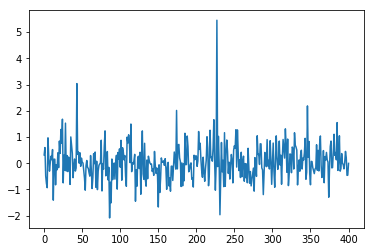

[('mood_mean', 1.52339852169728), ('appCat.entertainment_sum_time_1', 1.6298712467054282), ('appCat.entertainment_sum_time_2', -1.5008828412030626), ('appCat.office_sum_time_2', -4.814246602455994), ('appCat.office_sum_time_3', 4.920793792864882), ('appCat.entertainment_sum_time_4', 2.198475353025588), ('appCat.finance_sum_time_4', -2.2227565749498344), ('call_sum_time_4', 1.3913962125133807), ('mood_mean_time_5', 2.0875295200981685), ('appCat.entertainment_sum_time_5', -1.4763925826982662), ('appCat.finance_sum_time_5', 2.336659137894168), ('call_sum_time_5', -1.4001530893522913), ('lastTimeSeenMood_4', 15.4751900335465), ('lastTimeSeenMood_5', 2.3351171258809535)]


In [62]:
y_pred =clf.predict(dfTest[new_features])
print("MAE")
print(metrics.mean_absolute_error(dfTest['mood_mean_TARGET'],y_pred))
print("MSE")
print(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred))
print("RMSE")
print(np.sqrt(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred)))
print("R2")
print(metrics.r2_score(dfTest['mood_mean_TARGET'],y_pred))

import matplotlib.pyplot as plt
plt.plot(y_pred-dfTest['mood_mean_TARGET'])
plt.show()

print(list(zip(new_features,clf.coef_)))
allTogether = pd.concat([dfTest['mood_mean_TARGET'],dfTest[new_features]],axis=1)
allTogether['y_pred'] = y_pred
allTogether.to_csv("pred.csv")